# Register all patients
Run ANTs registration for every patient found in both `brains` and `locs`.


In [14]:
from pathlib import Path

import ants
import numpy as np
import pandas as pd
from scipy.io import loadmat
from templateflow import api as tflow

project_root = Path("../SuperEeg-M467-project")
brains_root = Path("../faces_basic/brains")
locs_root = Path("../faces_basic/locs")

# Single destination folder for all registered outputs
all_registered_dir = project_root / "registered_outputs"
all_registered_dir.mkdir(parents=True, exist_ok=True)

brain_ids = {p.name for p in brains_root.iterdir() if p.is_dir()}
loc_ids = {p.name.split("_")[0] for p in locs_root.glob("*_xslocs.mat")}
patient_ids = sorted(brain_ids & loc_ids)

print(f"Found {len(patient_ids)} shared patients: {patient_ids}")
print(f"Saving all registered outputs to: {all_registered_dir}")

#grabs the standard MNI template
mni_path = tflow.get("MNI152NLin2009cAsym", resolution=1, desc="brain", suffix="T1w")
template_img_ants = ants.image_read(str(mni_path))

for pid in patient_ids:
    mri_path = brains_root / pid / f"{pid}_mri.nii"
    loc_path = locs_root / f"{pid}_xslocs.mat"

    if not mri_path.exists():
        print(f"[{pid}] missing MRI: {mri_path}")
        continue
    if not loc_path.exists():
        print(f"[{pid}] missing locs: {loc_path}")
        continue

    print(f"\n[{pid}] registering...")

    raw_img_ants = ants.image_read(str(mri_path))
    transformation = ants.registration(
        fixed=template_img_ants,
        moving=raw_img_ants,
        type_of_transform="SyN",
        verbose=False,
    )

    registered_img_ants = transformation["warpedmovout"]
    out_mri_path = all_registered_dir / f"{pid}_mri_registered.nii"
    registered_img_ants.to_file(str(out_mri_path))

    locs_mm = np.asarray(loadmat(str(loc_path), squeeze_me=True)["locs"], dtype=float).reshape(-1, 3)
    pts_df = pd.DataFrame(locs_mm, columns=["x", "y", "z"])

    # For points, ANTs mapping is opposite image mapping.
    # Native (moving) -> template (fixed) uses invtransforms here.
    pts_fixed_df = ants.apply_transforms_to_points(
        dim=3,
        points=pts_df,
        transformlist=transformation["invtransforms"],
        whichtoinvert=[True, False],
    )

    locs_fixed_mm = pts_fixed_df[["x", "y", "z"]].to_numpy(dtype=np.float64)
    out_npy_path = all_registered_dir / f"{pid}_xslocs_registered_mm.npy"
    np.save(out_npy_path, locs_fixed_mm)

    print(f"[{pid}] MRI saved to: {out_mri_path}")
    print(f"[{pid}] locs saved to: {out_npy_path}  shape={locs_fixed_mm.shape}")

print("\nAll done.")


Found 14 shared patients: ['aa', 'ap', 'ca', 'de', 'fp', 'ha', 'ja', 'jm', 'jt', 'mv', 'rn', 'rr', 'wc', 'zt']
Saving all registered outputs to: ../SuperEeg-M467-project/registered_outputs


100%|██████████| 3.47M/3.47M [00:00<00:00, 6.33MB/s]



[aa] registering...
[aa] MRI saved to: ../SuperEeg-M467-project/registered_outputs/aa_mri_registered.nii
[aa] locs saved to: ../SuperEeg-M467-project/registered_outputs/aa_xslocs_registered_mm.npy  shape=(46, 3)

[ap] registering...
[ap] MRI saved to: ../SuperEeg-M467-project/registered_outputs/ap_mri_registered.nii
[ap] locs saved to: ../SuperEeg-M467-project/registered_outputs/ap_xslocs_registered_mm.npy  shape=(41, 3)

[ca] registering...
[ca] MRI saved to: ../SuperEeg-M467-project/registered_outputs/ca_mri_registered.nii
[ca] locs saved to: ../SuperEeg-M467-project/registered_outputs/ca_xslocs_registered_mm.npy  shape=(50, 3)

[de] registering...
[de] MRI saved to: ../SuperEeg-M467-project/registered_outputs/de_mri_registered.nii
[de] locs saved to: ../SuperEeg-M467-project/registered_outputs/de_xslocs_registered_mm.npy  shape=(31, 3)

[fp] registering...
[fp] MRI saved to: ../SuperEeg-M467-project/registered_outputs/fp_mri_registered.nii
[fp] locs saved to: ../SuperEeg-M467-proje

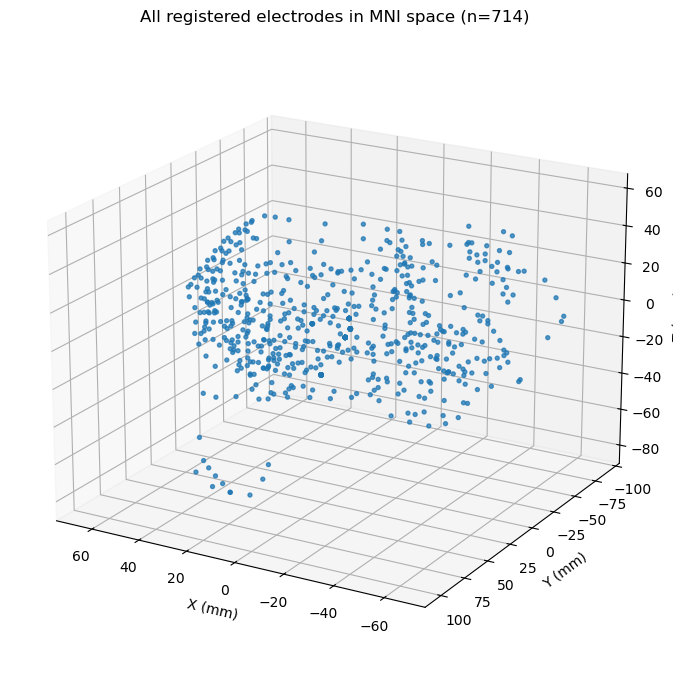

In [15]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

registered_dir = Path("../SuperEeg-M467-project/registered_outputs")
npy_files = sorted(registered_dir.glob("*_xslocs_registered_mm.npy"))

if not npy_files:
    raise FileNotFoundError(f"No registered electrode files found in: {registered_dir}")

all_points = []
for f in npy_files:
    pts = np.load(f)
    if pts.ndim == 2 and pts.shape[1] == 3:
        all_points.append(pts)

if not all_points:
    raise ValueError("No valid electrode coordinate arrays with shape (N, 3) were found.")

xyz = np.vstack(all_points)

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=8, alpha=0.75)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_title(f"All registered electrodes in MNI space (n={xyz.shape[0]})")
ax.view_init(elev=20, azim=120)

plt.tight_layout()
plt.show()


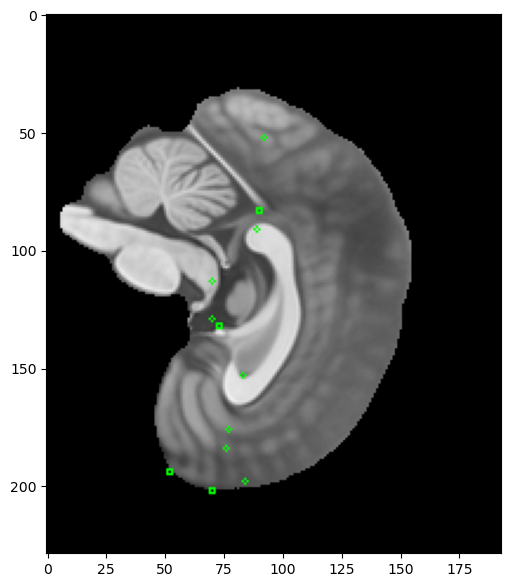

interactive(children=(IntSlider(value=96, description='SLICE', max=192), Output()), _dom_classes=('widget-inte…

In [16]:
from pathlib import Path
import numpy as np
import ants
from helpers import explore_3D_array_with_mask_contour

registered_dir = Path("../SuperEeg-M467-project/registered_outputs")
npy_files = sorted(registered_dir.glob("*_xslocs_registered_mm.npy"))

all_points = []
for f in npy_files:
    pts = np.load(f)
    if pts.ndim == 2 and pts.shape[1] == 3:
        all_points.append(pts)

if not all_points:
    raise ValueError(f"No valid electrode arrays found in {registered_dir}")

all_electrodes = np.vstack(all_points)
print(f"Loaded {all_electrodes.shape[0]} electrodes from {len(all_points)} patients")

template_img_ants = ants.image_read(str(mni_path))

elec_mask_template = (
    ants.make_points_image(
        all_electrodes,
        target=template_img_ants,
        radius=1,
    ).numpy() > 0
).astype(np.uint8)

print(f"Electrode voxels in full mask: {int(elec_mask_template.sum())}")

# Pick sagittal axis from image direction (robust to orientation conventions)
dir_mat = np.array(template_img_ants.direction)
if dir_mat.ndim == 1:
    dir_mat = dir_mat.reshape(3, 3)
sag_axis = int(np.argmax(np.abs(dir_mat[0, :])))

arr_sag = np.moveaxis(template_img_ants.numpy(), sag_axis, 0)
mask_sag = np.moveaxis(elec_mask_template, sag_axis, 0)

explore_3D_array_with_mask_contour(arr=arr_sag, mask=mask_sag)
